In [2]:
include("../code/sp.jl")
include("../code/matrix_generator.jl")
include("../code/slim_graphs.jl")
include("../code/bp.jl")
using ProgressMeter, StaticArrays, OffsetArrays, Statistics

In [3]:
callback(t, ε, sp) = (println("$t $ε"); false)

function decimate!(sp, indep; decsteps=10, callback=callback)
    H = sp.H
    freevars = copy(indep)
    iteration!(sp, maxiter=700, tol=1e-5, callback=callback, damp=0.5)
    sp_pre = deepcopy(sp)
    while !isempty(freevars)
        iteration!(sp, maxiter=100, tol=1e-3, damp=0.5)
        mag = map(p->p'eachindex(p), sp.survey)
        sort!(freevars, by=i->abs(mag[i]))
        freevars, tofix = freevars[1:end-decsteps], freevars[max(1,end-decsteps+1):end]
        sp.efield[tofix] .= sp.J.*sign.(mag[tofix])
    end
    sp_pre
end

decimate! (generic function with 2 methods)

In [11]:
f1 = 0.01
f3s = 0.1:0.05:0.6
# f3s = 0.3:0.05:0.35
Rs = fill(NaN, eachindex(f3s))
navg = 10
D_sp = [fill(NaN, navg) for _ in f3s]
y = 0.5
n = 300
K = OffsetVector([0,0,0,1], 0:3)
mK = sum(k*K[k] for k=eachindex(K))
J = 20
sps_pre = [Vector{SurveyPropagation{Bool, OffsetVector{Float64, Vector{Float64}}}}(undef, navg) for _ in f3s];
sps_post = [Vector{SurveyPropagation{Bool, OffsetVector{Float64, Vector{Float64}}}}(undef, navg) for _ in f3s];
sources = [[falses(n) for _ in 1:navg] for _ in f3s];

for (i,f3) in pairs(f3s)
    println("--- degree $i of $(length(f3s)): f3 = $f3 ---")
    flush(stdout)
    Λ = OffsetVector([0,f1,1-f1-f3,f3], 0:3)
    mΛ = sum(d*Λ[d] for d=eachindex(Λ))
    α = mΛ/mK; Rs[i]=1-α
    # Single instance
    nedges = Int(round(n*sum(i*l for (i,l) in pairs(Λ)), digits=8))
    m = Int(nedges/3)
    dist = zeros(navg)
    for k in 1:navg
        println("Avg $k of $navg")
        Ht = ldpc_matrix(n, m, nedges, Λ, K)
        H = permutedims(Ht)
        B,indep = findbasis_slow(Array(H))
        x0 = bitrand(size(H,2))
        sources[i][k] = x0
        s = (-1) .^ x0
        init = OffsetArray(MVector{2J+1}(fill(0.0,2J+1)), -J:J)
        init[-1:1] .= 1/3
        sp = survey_propagation(H; field=copy(s), init=copy(init), y=y)
        sps_pre[i][k] = decimate!(sp, indep; decsteps=1, callback=(x...)->false)
        sps_post[i][k] = sp
        mag = sign.(map(p->p'eachindex(p), sp.survey))
        x = mag .== -1
        w = sparse(B*x[indep] .% 2)
        println("Nunsat = ", sum(H*x .% 2))
        D_sp[i][k] = mean(w .!= x0)
    end
end

--- degree 1 of 11: f3 = 0.1 ---
Avg 1 of 10
(ss, i) = (1.095102759000583, 32)
(ss, i) = (1.0899967272652906, 32)
(ss, i) = (1.085527903316156, 32)
(ss, i) = (1.080347055051798, 32)
(ss, i) = (1.0735811637346464, 32)
(ss, i) = (1.0649965988430214, 32)
(ss, i) = (1.0884213484540126, 240)
(ss, i) = (1.0549871215231423, 32)
(ss, i) = (1.0958657112312817, 107)
(ss, i) = (1.072852685326727, 240)
(ss, i) = (1.044368205485148, 32)
(ss, i) = (1.0794729693462566, 107)
(ss, i) = (1.0584040089561104, 240)
(ss, i) = (1.034072085924734, 32)
(ss, i) = (1.063878992573364, 107)
(ss, i) = (1.0964842482684218, 128)
(ss, i) = (1.0456655021301464, 240)
(ss, i) = (1.0248774767649744, 32)
(ss, i) = (1.0497289822464033, 107)
(ss, i) = (1.0690984278001037, 128)
(ss, i) = (1.034899778365782, 240)
(ss, i) = (1.017260503095933, 32)
(ss, i) = (1.080230764596487, 78)
(ss, i) = (1.0932175997789648, 80)
(ss, i) = (1.037458103965832, 107)
(ss, i) = (1.0484956802138221, 128)
(ss, i) = (1.0261179569653303, 240)
(ss, i)

(ss, i) = (1.0503050835227836, 92)
(ss, i) = (1.0139256075105503, 107)
(ss, i) = (1.0838127558096422, 158)
(ss, i) = (1.011554403024125, 205)
(ss, i) = (1.0234820421401927, 211)
(ss, i) = (1.0017283046066894, 213)
(ss, i) = (1.0309543403263661, 240)
(ss, i) = (1.051905872227537, 17)
(ss, i) = (1.0113041738632285, 20)
(ss, i) = (1.0000920178821104, 32)
(ss, i) = (1.000122602830876, 35)
(ss, i) = (1.0534981183248882, 69)
(ss, i) = (1.0000387594971074, 78)
(ss, i) = (1.0629367772071665, 92)
(ss, i) = (1.0156442239766044, 107)
(ss, i) = (1.0114178561569458, 205)
(ss, i) = (1.0161332669128231, 211)
(ss, i) = (1.0011796917036455, 213)
(ss, i) = (1.0327171709228697, 240)
(ss, i) = (1.0721130383555462, 17)
(ss, i) = (1.0127736208088427, 20)
(ss, i) = (1.000175113368342, 32)
(ss, i) = (1.0001211361443123, 35)
(ss, i) = (1.0748540935294726, 69)
(ss, i) = (1.0000583474152984, 78)
(ss, i) = (1.0847964593487567, 92)
(ss, i) = (1.0177981211602367, 107)
(ss, i) = (1.0113889482923726, 205)
(ss, i) = (

(ss, i) = (1.0298778229913372, 240)
(ss, i) = (1.0078431468623184, 17)
(ss, i) = (1.0326825239865594, 20)
(ss, i) = (1.0969247386186476, 26)
(ss, i) = (1.0001979119968998, 32)
(ss, i) = (1.0013033832640705, 35)
(ss, i) = (1.039648789979284, 52)
(ss, i) = (1.0949702731703332, 68)
(ss, i) = (1.025809873088153, 69)
(ss, i) = (1.0002800588394078, 78)
(ss, i) = (1.0706588125093008, 92)
(ss, i) = (1.0261065389770267, 96)
(ss, i) = (1.0584194053702636, 102)
(ss, i) = (1.0369591277882426, 107)
(ss, i) = (1.0626434796326745, 140)
(ss, i) = (1.0453934139511105, 151)
(ss, i) = (1.04526212058665, 158)
(ss, i) = (1.0970600086157716, 188)
(ss, i) = (1.0185074988454375, 194)
(ss, i) = (1.0219107926395663, 205)
(ss, i) = (1.0168633646955483, 211)
(ss, i) = (1.005300490699818, 213)
(ss, i) = (1.0409411660748575, 215)
(ss, i) = (1.0290429230921783, 240)
(ss, i) = (1.0086705533361393, 17)
(ss, i) = (1.035521032716005, 20)
(ss, i) = (1.0003052336671323, 32)
(ss, i) = (1.0014686075851207, 35)
(ss, i) = (1.

(ss, i) = (1.0699166788740955, 128)
(ss, i) = (1.0251267497402419, 134)
(ss, i) = (1.0989145811290943, 140)
(ss, i) = (1.0316251293358927, 151)
(ss, i) = (1.0923516325429894, 158)
(ss, i) = (1.0084522379955447, 160)
(ss, i) = (1.0393255226460727, 169)
(ss, i) = (1.0814385591398776, 188)
(ss, i) = (1.0110465338565873, 194)
(ss, i) = (1.029803015480783, 205)
(ss, i) = (1.0141050197037609, 211)
(ss, i) = (1.0069093638547142, 213)
(ss, i) = (1.0245929308738488, 215)
(ss, i) = (1.0214198103292191, 240)
(ss, i) = (1.020866771251017, 17)
(ss, i) = (1.024315945171552, 20)
(ss, i) = (1.0797305329148428, 22)
(ss, i) = (1.0766286626537342, 26)
(ss, i) = (1.075268633800728, 29)
(ss, i) = (1.000646452180266, 32)
(ss, i) = (1.0025082253511297, 35)
(ss, i) = (1.0286537329193584, 40)
(ss, i) = (1.0380055703142896, 52)
(ss, i) = (1.0267462266401568, 64)
(ss, i) = (1.0318065679842758, 68)
(ss, i) = (1.0007745155142305, 78)
(ss, i) = (1.0707027875136184, 80)
(ss, i) = (1.0310714905891012, 96)
(ss, i) = (

(ss, i) = (1.0908084793751631, 26)
(ss, i) = (1.069216734027409, 29)
(ss, i) = (1.0005697230304933, 32)
(ss, i) = (1.0013615228292112, 35)
(ss, i) = (1.07141886660905, 37)
(ss, i) = (1.0995953136469736, 52)
(ss, i) = (1.0234917848017275, 64)
(ss, i) = (1.0193758281761007, 68)
(ss, i) = (1.093947550864862, 69)
(ss, i) = (1.0005247675475288, 78)
(ss, i) = (1.0751564545657286, 80)
(ss, i) = (1.0803164205676488, 93)
(ss, i) = (1.0162181627851556, 96)
(ss, i) = (1.0192266438773858, 107)
(ss, i) = (1.064312425185398, 128)
(ss, i) = (1.0234917870837275, 134)
(ss, i) = (1.0855930259269146, 158)
(ss, i) = (1.0103401835575356, 160)
(ss, i) = (1.08695295063589, 161)
(ss, i) = (1.090806255514098, 166)
(ss, i) = (1.0880918997838813, 188)
(ss, i) = (1.0310360745512703, 194)
(ss, i) = (1.0238263000431942, 205)
(ss, i) = (1.0140144801804853, 211)
(ss, i) = (1.0041960729525368, 213)
(ss, i) = (1.0439181831874493, 215)
(ss, i) = (1.0159398469401189, 240)
(ss, i) = (1.0145688717004586, 17)
(ss, i) = (1.0

(ss, i) = (1.0445487512604474, 26)
(ss, i) = (1.0410284146519027, 29)
(ss, i) = (1.0070310425907876, 32)
(ss, i) = (1.0719577735499997, 40)
(ss, i) = (1.0451203180156317, 52)
(ss, i) = (1.0283103594532763, 64)
(ss, i) = (1.0302644900674052, 68)
(ss, i) = (1.0562243417615316, 69)
(ss, i) = (1.0358752322742835, 80)
(ss, i) = (1.0277391285446924, 96)
(ss, i) = (1.004872818792996, 107)
(ss, i) = (1.0959001292576713, 116)
(ss, i) = (1.035199070647716, 128)
(ss, i) = (1.0808393690199338, 132)
(ss, i) = (1.0283103497978754, 134)
(ss, i) = (1.0446628603352164, 151)
(ss, i) = (1.0449547975947298, 158)
(ss, i) = (1.0096338453959401, 160)
(ss, i) = (1.0872443596409183, 169)
(ss, i) = (1.0388991245282417, 188)
(ss, i) = (1.0133588345053075, 194)
(ss, i) = (1.010251342065575, 205)
(ss, i) = (1.0656860690067917, 211)
(ss, i) = (1.0528375896259456, 215)
(ss, i) = (1.0151583218484517, 17)
(ss, i) = (1.0065409643246044, 20)
(ss, i) = (1.0402344839955378, 26)
(ss, i) = (1.0395410741954776, 29)
(ss, i) =

(ss, i) = (1.0144317117374773, 134)
(ss, i) = (1.042441696910428, 156)
(ss, i) = (1.012470837383529, 158)
(ss, i) = (1.0074808311385723, 160)
(ss, i) = (1.011871533591253, 188)
(ss, i) = (1.0210572113160175, 194)
(ss, i) = (1.0023428061937594, 205)
(ss, i) = (1.045496353989135, 219)
(ss, i) = (1.0033130304261115, 17)
(ss, i) = (1.0100788346147287, 18)
(ss, i) = (1.001126579289346, 20)
(ss, i) = (1.0124527228631464, 26)
(ss, i) = (1.01772816499948, 29)
(ss, i) = (1.0011264660015604, 32)
(ss, i) = (1.0126662230377885, 64)
(ss, i) = (1.0080282669576608, 68)
(ss, i) = (1.0143079872779488, 69)
(ss, i) = (1.012373727764475, 80)
(ss, i) = (1.0514949054963394, 92)
(ss, i) = (1.0050605096722007, 96)
(ss, i) = (1.0005060747902843, 107)
(ss, i) = (1.0352120893166668, 108)
(ss, i) = (1.0104539190967847, 116)
(ss, i) = (1.0140563828796567, 128)
(ss, i) = (1.0067760331593083, 129)
(ss, i) = (1.0102720456496745, 132)
(ss, i) = (1.0126662236613357, 134)
(ss, i) = (1.0821818055696097, 152)
(ss, i) = (1

(ss, i) = (1.0155268349119417, 128)
(ss, i) = (1.0000760956550143, 129)
(ss, i) = (1.0001575474448572, 132)
(ss, i) = (1.010322828359311, 134)
(ss, i) = (1.003481303767009, 138)
(ss, i) = (1.004221380867217, 142)
(ss, i) = (1.001280662313859, 152)
(ss, i) = (1.0422020374633314, 156)
(ss, i) = (1.0138765330806538, 158)
(ss, i) = (1.0027058442886674, 160)
(ss, i) = (1.0516235579207551, 169)
(ss, i) = (1.03505160264448, 171)
(ss, i) = (1.0138761681558903, 188)
(ss, i) = (1.0001023518024963, 194)
(ss, i) = (1.0000901117412353, 205)
(ss, i) = (1.0502353471312604, 215)
(ss, i) = (1.0004434020842996, 219)
(ss, i) = (1.0019727496143696, 279)
(ss, i) = (1.0096299042259451, 17)
(ss, i) = (1.0001243988883215, 18)
(ss, i) = (1.0000273948160225, 20)
(ss, i) = (1.0221865212641257, 21)
(ss, i) = (1.0153315522952626, 26)
(ss, i) = (1.0150717872646533, 29)
(ss, i) = (1.0000273480466626, 32)
(ss, i) = (1.0119543216174067, 64)
(ss, i) = (1.0177333576034815, 68)
(ss, i) = (1.0153360194076686, 69)
(ss, i) 

(ss, i) = (1.0152766110022335, 53)
(ss, i) = (1.0218181321238218, 64)
(ss, i) = (1.0198230786029794, 68)
(ss, i) = (1.0068612489771662, 69)
(ss, i) = (1.0020319509554427, 76)
(ss, i) = (1.0516182020257114, 77)
(ss, i) = (1.0123349370099797, 80)
(ss, i) = (1.0259154071403873, 92)
(ss, i) = (1.0003064646381954, 95)
(ss, i) = (1.0144042901369514, 96)
(ss, i) = (1.0110393997395244, 97)
(ss, i) = (1.0205281899430947, 99)
(ss, i) = (1.0000022550258483, 107)
(ss, i) = (1.0095400585719523, 108)
(ss, i) = (1.0000203053909344, 116)
(ss, i) = (1.0550856212947994, 126)
(ss, i) = (1.0154949162856124, 128)
(ss, i) = (1.0000229930476792, 129)
(ss, i) = (1.0000386277657574, 132)
(ss, i) = (1.0872362452014752, 133)
(ss, i) = (1.021818132221623, 134)
(ss, i) = (1.000318012489229, 138)
(ss, i) = (1.0002679086430386, 142)
(ss, i) = (1.0153724530385657, 150)
(ss, i) = (1.0001279072803573, 152)
(ss, i) = (1.0263415590445892, 156)
(ss, i) = (1.0048162456950167, 158)
(ss, i) = (1.0077762822316654, 160)
(ss, i

(ss, i) = (1.0089000533061268, 215)
(ss, i) = (1.0005052252851885, 219)
(ss, i) = (1.0533479620658148, 222)
(ss, i) = (1.0000570229675254, 240)
(ss, i) = (1.0002638026588506, 279)
(ss, i) = (1.0080613999118548, 3)
(ss, i) = (1.0031392631453646, 15)
(ss, i) = (1.004742407596338, 17)
(ss, i) = (1.0009396524954124, 18)
(ss, i) = (1.000046826258865, 20)
(ss, i) = (1.001069523836602, 21)
(ss, i) = (1.0238588198348264, 27)
(ss, i) = (1.0000774470906135, 32)
(ss, i) = (1.002095523425791, 40)
(ss, i) = (1.0031571345258155, 53)
(ss, i) = (1.053159427541022, 62)
(ss, i) = (1.014425866082506, 64)
(ss, i) = (1.0102363745019467, 68)
(ss, i) = (1.008233380929822, 69)
(ss, i) = (1.0018996689630362, 76)
(ss, i) = (1.0828920822238948, 77)
(ss, i) = (1.0219856343223819, 85)
(ss, i) = (1.0158161281823768, 92)
(ss, i) = (1.0006504918850176, 95)
(ss, i) = (1.0076615933801634, 96)
(ss, i) = (1.0057033171851084, 97)
(ss, i) = (1.0540522548598505, 99)
(ss, i) = (1.0000453141520276, 107)
(ss, i) = (1.069029092

(ss, i) = (1.0471572439293164, 87)
(ss, i) = (1.018191513979894, 95)
(ss, i) = (1.0012403181438967, 107)
(ss, i) = (1.0071420745865711, 116)
(ss, i) = (1.006950672033528, 132)
(ss, i) = (1.0933505738500653, 134)
(ss, i) = (1.018469760003244, 142)
(ss, i) = (1.0194713345132567, 150)
(ss, i) = (1.050589816347329, 152)
(ss, i) = (1.013234329347637, 160)
(ss, i) = (1.0184902287450999, 171)
(ss, i) = (1.0220721485926691, 178)
(ss, i) = (1.0842347348627461, 183)
(ss, i) = (1.0596916360585698, 193)
(ss, i) = (1.0613403878440335, 194)
(ss, i) = (1.0323580788804754, 196)
(ss, i) = (1.0594840800990424, 201)
(ss, i) = (1.0003125853019856, 205)
(ss, i) = (1.0026927600524076, 240)
(ss, i) = (1.0407254987802976, 279)
(ss, i) = (1.0114314316917767, 3)
(ss, i) = (1.0284252107004959, 15)
(ss, i) = (1.0897700352431523, 18)
(ss, i) = (1.0115541568226765, 19)
(ss, i) = (1.0018038075416857, 20)
(ss, i) = (1.0339852756860748, 27)
(ss, i) = (1.0001964122858973, 32)
(ss, i) = (1.0115348277043994, 45)
(ss, i) 

(ss, i) = (1.0116288385771994, 29)
(ss, i) = (1.000231251295613, 32)
(ss, i) = (1.0794392733832918, 35)
(ss, i) = (1.0688402237592505, 37)
(ss, i) = (1.0420553960939969, 40)
(ss, i) = (1.0576727779601516, 69)
(ss, i) = (1.0137989048917264, 80)
(ss, i) = (1.0576347797581995, 102)
(ss, i) = (1.000990722662894, 107)
(ss, i) = (1.0624137950047436, 108)
(ss, i) = (1.018507657995028, 116)
(ss, i) = (1.0128804462591559, 128)
(ss, i) = (1.0027312095309677, 129)
(ss, i) = (1.018475897386683, 132)
(ss, i) = (1.0655626198017456, 156)
(ss, i) = (1.0242580891734234, 158)
(ss, i) = (1.0549468523988585, 166)
(ss, i) = (1.0431027153359107, 169)
(ss, i) = (1.0149931664999774, 188)
(ss, i) = (1.0007837359090315, 194)
(ss, i) = (1.0026775749479864, 205)
(ss, i) = (1.0381162725803639, 211)
(ss, i) = (1.0502570527647026, 213)
(ss, i) = (1.036409823944295, 215)
(ss, i) = (1.036711738818725, 219)
(ss, i) = (1.0115103142162825, 240)
(ss, i) = (1.0337496188976107, 17)
(ss, i) = (1.0094228487101473, 18)
(ss, i)

(ss, i) = (1.003048538762914, 152)
(ss, i) = (1.0470344060798782, 156)
(ss, i) = (1.02671368288856, 158)
(ss, i) = (1.0666214813047126, 160)
(ss, i) = (1.0440098214348417, 171)
(ss, i) = (1.0269750961588233, 188)
(ss, i) = (1.0009506714903351, 194)
(ss, i) = (1.0001600965424735, 205)
(ss, i) = (1.0021751730474313, 219)
(ss, i) = (1.0006283095947284, 240)
(ss, i) = (1.0039170439518685, 279)
(ss, i) = (1.0165754405733594, 17)
(ss, i) = (1.0006836338905851, 18)
(ss, i) = (1.0000401522377254, 20)
(ss, i) = (1.0349188709836286, 21)
(ss, i) = (1.0243609009608035, 26)
(ss, i) = (1.016830934036099, 29)
(ss, i) = (1.0000326586931598, 32)
(ss, i) = (1.048400783824169, 64)
(ss, i) = (1.0239837040571467, 68)
(ss, i) = (1.0239174295104216, 69)
(ss, i) = (1.0339732914811313, 76)
(ss, i) = (1.0252537439163276, 80)
(ss, i) = (1.0954676325284562, 89)
(ss, i) = (1.0523880235829366, 92)
(ss, i) = (1.0050112415566042, 95)
(ss, i) = (1.0264417559615644, 96)
(ss, i) = (1.0000153933984652, 107)
(ss, i) = (1.

(ss, i) = (1.0900297723016814, 186)
(ss, i) = (1.0647475894482255, 205)
(ss, i) = (1.08979019643893, 186)
(ss, i) = (1.064749281009039, 205)
(ss, i) = (1.0895155917019788, 186)
(ss, i) = (1.0647246047369319, 205)
(ss, i) = (1.0892262156342905, 186)
(ss, i) = (1.0646718938352613, 205)
(ss, i) = (1.088942239335466, 186)
(ss, i) = (1.0645947280209762, 205)
(ss, i) = (1.0886799530114204, 186)
(ss, i) = (1.0645007368304302, 205)
(ss, i) = (1.0884501332640721, 186)
(ss, i) = (1.0643995933485972, 205)
(ss, i) = (1.0882581460996368, 186)
(ss, i) = (1.0643009499329967, 205)
(ss, i) = (1.0881050851075478, 186)
(ss, i) = (1.0642128171931768, 205)
(ss, i) = (1.0879892990184552, 186)
(ss, i) = (1.064140595038947, 205)
(ss, i) = (1.0879078506799622, 186)
(ss, i) = (1.0640867465110413, 205)
(ss, i) = (1.0878576491359933, 186)
(ss, i) = (1.0640509875170805, 205)
(ss, i) = (1.0878361562603573, 186)
(ss, i) = (1.0640308258990212, 205)
(ss, i) = (1.0878416791130392, 186)
(ss, i) = (1.0640222875671637, 20

(ss, i) = (1.0977547907059322, 186)
(ss, i) = (1.0659655274088617, 205)
(ss, i) = (1.0982356590743367, 186)
(ss, i) = (1.0660992331971142, 205)
(ss, i) = (1.0987259804561766, 186)
(ss, i) = (1.0662524983183066, 205)
(ss, i) = (1.0992169042777475, 186)
(ss, i) = (1.0664222730419302, 205)
(ss, i) = (1.0996997476744488, 186)
(ss, i) = (1.0666048219458895, 205)
(ss, i) = (1.0667959922586554, 205)
(ss, i) = (1.0669914786476802, 205)
(ss, i) = (1.0671870644702566, 205)
(ss, i) = (1.0673788247401037, 205)
(ss, i) = (1.067563281444616, 205)
(ss, i) = (1.0677375069488502, 205)
(ss, i) = (1.0678991757616654, 205)
(ss, i) = (1.0680465687267282, 205)
(ss, i) = (1.06817853660902, 205)
(ss, i) = (1.0682944320075234, 205)
(ss, i) = (1.0683940195339718, 205)
(ss, i) = (1.0684773743230154, 205)
(ss, i) = (1.068544778311122, 205)
(ss, i) = (1.068596622514744, 205)
(ss, i) = (1.068633321946078, 205)
(ss, i) = (1.0686552480131284, 205)
(ss, i) = (1.0686626814184215, 205)
(ss, i) = (1.0686557868184117, 205

(ss, i) = (1.0695809364281534, 205)
(ss, i) = (1.069600820233023, 205)
(ss, i) = (1.0696212872575779, 205)
(ss, i) = (1.0696422994484847, 205)
(ss, i) = (1.069663823074757, 205)
(ss, i) = (1.069685828616794, 205)
(ss, i) = (1.0697082905638027, 205)
(ss, i) = (1.0697311871217638, 205)
(ss, i) = (1.0697544998371002, 205)
(ss, i) = (1.0697782131440534, 205)
(ss, i) = (1.0698023138463748, 205)
(ss, i) = (1.06982679054617, 205)
(ss, i) = (1.0698516330344767, 205)
(ss, i) = (1.0698768316593203, 205)
(ss, i) = (1.0699023766876246, 205)
(ss, i) = (1.0699282576773226, 205)
(ss, i) = (1.0699544628754327, 205)
(ss, i) = (1.0699809786567562, 205)
(ss, i) = (1.0700077890162587, 205)
(ss, i) = (1.0700348751262454, 205)
(ss, i) = (1.0700622149672006, 205)
(ss, i) = (1.0700897830387657, 205)
(ss, i) = (1.070117550154842, 205)
(ss, i) = (1.070145483324397, 205)
(ss, i) = (1.0701735457172328, 205)
(ss, i) = (1.0702016967118932, 205)
(ss, i) = (1.0702298920210733, 205)
(ss, i) = (1.0702580838883913, 205)

(ss, i) = (1.0719523836606715, 205)
(ss, i) = (1.0718390155344881, 205)
(ss, i) = (1.0717279062639755, 205)
(ss, i) = (1.071620566405191, 205)
(ss, i) = (1.0715184151673167, 205)
(ss, i) = (1.0714227376763277, 205)
(ss, i) = (1.0713346523971228, 205)
(ss, i) = (1.0712550892254487, 205)
(ss, i) = (1.0711847779412778, 205)
(ss, i) = (1.071124246075321, 205)
(ss, i) = (1.071073824799695, 205)
(ss, i) = (1.0710336612089102, 205)
(ss, i) = (1.0710037352876407, 205)
(ss, i) = (1.0709838799354165, 205)
(ss, i) = (1.070973802597355, 205)
(ss, i) = (1.070973107294685, 205)
(ss, i) = (1.0709813161213972, 205)
(ss, i) = (1.070997889541279, 205)
(ss, i) = (1.071022245057604, 205)
(ss, i) = (1.0710537740194486, 205)
(ss, i) = (1.0710918564666758, 205)
(ss, i) = (1.07113587400128, 205)
(ss, i) = (1.071185220714194, 205)
(ss, i) = (1.0712393122064339, 205)
(ss, i) = (1.0712975927365207, 205)
(ss, i) = (1.0713595405165188, 205)
(ss, i) = (1.0714246711785353, 205)
(ss, i) = (1.0714925394494732, 205)
(s

(ss, i) = (1.0946574337891275, 186)
(ss, i) = (1.0578001297892932, 205)
(ss, i) = (1.0947075800877009, 186)
(ss, i) = (1.057889384008354, 205)
(ss, i) = (1.0947720408228507, 186)
(ss, i) = (1.0579882084799774, 205)
(ss, i) = (1.094849808702411, 186)
(ss, i) = (1.058096314960377, 205)
(ss, i) = (1.0949396534165392, 186)
(ss, i) = (1.0582133162978307, 205)
(ss, i) = (1.0950401645603576, 186)
(ss, i) = (1.0583387338572245, 205)
(ss, i) = (1.0951497964203614, 186)
(ss, i) = (1.0584720090719435, 205)
(ss, i) = (1.0952669132164212, 186)
(ss, i) = (1.0586125182575485, 205)
(ss, i) = (1.095389833545661, 186)
(ss, i) = (1.0587595897466495, 205)
(ss, i) = (1.0955168729423932, 186)
(ss, i) = (1.0589125223819855, 205)
(ss, i) = (1.095646383636696, 186)
(ss, i) = (1.059070604428638, 205)
(ss, i) = (1.0957767907543365, 186)
(ss, i) = (1.05923313202869, 205)
(ss, i) = (1.0959066243479572, 186)
(ss, i) = (1.0593630306059874, 205)
(ss, i) = (1.0960470084505394, 186)
(ss, i) = (1.059385504195682, 205)
(

(ss, i) = (1.081939356758004, 205)
(ss, i) = (1.082291190363691, 205)
(ss, i) = (1.0826651886693526, 205)
(ss, i) = (1.0830624665975588, 205)
(ss, i) = (1.0834839398545912, 205)
(ss, i) = (1.0839302939768367, 205)
(ss, i) = (1.0844019681122925, 205)
(ss, i) = (1.0848991537278956, 205)
(ss, i) = (1.085421807462478, 205)
(ss, i) = (1.0859696764521414, 205)
(ss, i) = (1.086542333715491, 205)
(ss, i) = (1.0871392206573425, 205)
(ss, i) = (1.087759693463554, 205)
(ss, i) = (1.0884030701229308, 205)
(ss, i) = (1.0890686750066665, 205)
(ss, i) = (1.0897558783238668, 205)
(ss, i) = (1.0904641283022367, 205)
(ss, i) = (1.091192974558443, 205)
(ss, i) = (1.091942081766098, 205)
(ss, i) = (1.0927112333501423, 205)
(ss, i) = (1.093500325495066, 205)
(ss, i) = (1.0943093522246818, 205)
(ss, i) = (1.0951377648493803, 205)
(ss, i) = (1.0959836936394978, 205)
(ss, i) = (1.096843857805994, 205)
(ss, i) = (1.097714359035179, 205)
(ss, i) = (1.0985918991628736, 205)
(ss, i) = (1.0994748028411705, 205)
(s

(ss, i) = (1.0808565774098673, 262)
(ss, i) = (1.0854624256981977, 282)
(ss, i) = (1.0861662393345364, 40)
(ss, i) = (1.0896099209867733, 47)
(ss, i) = (1.0847760117771663, 112)
(ss, i) = (1.0902547970074081, 115)
(ss, i) = (1.0844721038013776, 123)
(ss, i) = (1.0951027861555707, 126)
(ss, i) = (1.0529956994183023, 186)
(ss, i) = (1.080517558605668, 205)
(ss, i) = (1.0805316535078018, 262)
(ss, i) = (1.0854390238805898, 282)
(ss, i) = (1.085871105249326, 40)
(ss, i) = (1.0925204147855383, 47)
(ss, i) = (1.0842632073505087, 112)
(ss, i) = (1.088904464315332, 115)
(ss, i) = (1.0833352482854997, 123)
(ss, i) = (1.0961968446547805, 126)
(ss, i) = (1.0543294089710797, 186)
(ss, i) = (1.0785301276852401, 205)
(ss, i) = (1.0804079101456645, 262)
(ss, i) = (1.0856046607271033, 282)
(ss, i) = (1.0857860051963837, 40)
(ss, i) = (1.0955912775229437, 47)
(ss, i) = (1.0839744906200381, 112)
(ss, i) = (1.0878740897048136, 115)
(ss, i) = (1.0824989952955069, 123)
(ss, i) = (1.0972504918384396, 126)
(

(ss, i) = (1.082565523971623, 40)
(ss, i) = (1.0887461107859, 112)
(ss, i) = (1.0891770715315066, 115)
(ss, i) = (1.0866728133497063, 120)
(ss, i) = (1.0813300140318416, 123)
(ss, i) = (1.0467689990174276, 205)
(ss, i) = (1.082280300595913, 251)
(ss, i) = (1.0801342345669682, 262)
(ss, i) = (1.084374462820056, 282)
(ss, i) = (1.08354604023247, 40)
(ss, i) = (1.0886347362337176, 112)
(ss, i) = (1.0889346983225132, 115)
(ss, i) = (1.0851632212153346, 120)
(ss, i) = (1.0805286001375565, 123)
(ss, i) = (1.0435327011129465, 205)
(ss, i) = (1.0804552273748729, 251)
(ss, i) = (1.0806357303032077, 262)
(ss, i) = (1.0853959828690114, 282)
(ss, i) = (1.0844039361682667, 40)
(ss, i) = (1.0882996076906049, 112)
(ss, i) = (1.0885032068865375, 115)
(ss, i) = (1.0837252595734508, 120)
(ss, i) = (1.0796550943857912, 123)
(ss, i) = (1.0405583911384968, 205)
(ss, i) = (1.078886382408135, 251)
(ss, i) = (1.0809580697221957, 262)
(ss, i) = (1.0862863261262605, 282)
(ss, i) = (1.0979419131343666, 20)
(ss, 

(ss, i) = (1.08408628156684, 178)
(ss, i) = (1.02399706856655, 201)
(ss, i) = (1.0246855942133624, 205)
(ss, i) = (1.0265982940320997, 222)
(ss, i) = (1.0940588967794929, 262)
(ss, i) = (1.0968782032259563, 282)
(ss, i) = (1.0193250430019278, 297)
(ss, i) = (1.0290934202969746, 20)
(ss, i) = (1.0799937879328367, 32)
(ss, i) = (1.0949725623224171, 40)
(ss, i) = (1.069170402398389, 45)
(ss, i) = (1.070414004442876, 62)
(ss, i) = (1.0183891546956922, 106)
(ss, i) = (1.0600790291953903, 107)
(ss, i) = (1.0200888764883784, 110)
(ss, i) = (1.0460661804360147, 160)
(ss, i) = (1.0547038240052993, 161)
(ss, i) = (1.0820661745086437, 178)
(ss, i) = (1.0231764894330637, 201)
(ss, i) = (1.024379850024888, 205)
(ss, i) = (1.026104460489124, 222)
(ss, i) = (1.0964648987997616, 262)
(ss, i) = (1.0994326522890308, 282)
(ss, i) = (1.0181433709032142, 297)
(ss, i) = (1.028805502658287, 20)
(ss, i) = (1.0791518935853812, 32)
(ss, i) = (1.0974240557071913, 40)
(ss, i) = (1.0673709154216044, 45)
(ss, i) = 

(ss, i) = (1.0729073994765674, 120)
(ss, i) = (1.0892047241878169, 123)
(ss, i) = (1.0586170701256084, 160)
(ss, i) = (1.055247060680219, 161)
(ss, i) = (1.068760784540586, 178)
(ss, i) = (1.032749576915378, 201)
(ss, i) = (1.0378788007466442, 205)
(ss, i) = (1.0439989308232906, 222)
(ss, i) = (1.0741655748745509, 251)
(ss, i) = (1.020871475133371, 297)
(ss, i) = (1.0504379810108502, 20)
(ss, i) = (1.0976819900088837, 45)
(ss, i) = (1.0746919304739653, 62)
(ss, i) = (1.0241873055571378, 106)
(ss, i) = (1.0663137905831184, 107)
(ss, i) = (1.0287921252406265, 110)
(ss, i) = (1.0727470813834792, 120)
(ss, i) = (1.0867687412041838, 123)
(ss, i) = (1.0561274917007766, 160)
(ss, i) = (1.0579570249762607, 161)
(ss, i) = (1.0711118249682294, 178)
(ss, i) = (1.0359952620165034, 201)
(ss, i) = (1.040685092907394, 205)
(ss, i) = (1.0484846717098328, 222)
(ss, i) = (1.0740724032995321, 251)
(ss, i) = (1.0223087391331345, 297)
(ss, i) = (1.055207270703851, 20)
(ss, i) = (1.079856142018056, 62)
(ss,

(ss, i) = (1.0874540970980628, 106)
(ss, i) = (1.0302650243137683, 160)
(ss, i) = (1.071956832800967, 205)
(ss, i) = (1.0876573287605693, 235)
(ss, i) = (1.0948975315474545, 262)
(ss, i) = (1.0754648404486156, 297)
(ss, i) = (1.0738297903093517, 40)
(ss, i) = (1.093066400779211, 106)
(ss, i) = (1.0301086936643995, 160)
(ss, i) = (1.0712441113679607, 205)
(ss, i) = (1.089123794550064, 235)
(ss, i) = (1.097148590963392, 262)
(ss, i) = (1.081491051582349, 297)
(ss, i) = (1.0750015805622106, 40)
(ss, i) = (1.0985147047979242, 106)
(ss, i) = (1.0300696803041034, 160)
(ss, i) = (1.0701813049449342, 205)
(ss, i) = (1.0907205152395587, 235)
(ss, i) = (1.0996511056477634, 262)
(ss, i) = (1.087719561286364, 297)
(ss, i) = (1.0766373902883635, 40)
(ss, i) = (1.0301340478089194, 160)
(ss, i) = (1.0688256273371515, 205)
(ss, i) = (1.092393742399468, 235)
(ss, i) = (1.0940708808744573, 297)
(ss, i) = (1.078706000134039, 40)
(ss, i) = (1.030289148105744, 160)
(ss, i) = (1.0672399323942392, 205)
(ss, 

(ss, i) = (1.0738134361504779, 20)
(ss, i) = (1.0648896447519856, 101)
(ss, i) = (1.082495496910152, 106)
(ss, i) = (1.0813828743829896, 110)
(ss, i) = (1.0912005857278122, 112)
(ss, i) = (1.0912023412018048, 115)
(ss, i) = (1.083676108528646, 120)
(ss, i) = (1.081806410669465, 123)
(ss, i) = (1.061340647495273, 146)
(ss, i) = (1.078865675897874, 160)
(ss, i) = (1.076188563683396, 179)
(ss, i) = (1.07556769436282, 201)
(ss, i) = (1.04476420795512, 205)
(ss, i) = (1.074340810765629, 222)
(ss, i) = (1.0809043486030716, 235)
(ss, i) = (1.0803099407115906, 251)
(ss, i) = (1.0908865756357513, 297)
(ss, i) = (1.0736613944223103, 20)
(ss, i) = (1.066219113382952, 101)
(ss, i) = (1.0820968463811012, 106)
(ss, i) = (1.081345181447094, 110)
(ss, i) = (1.0902299069920067, 112)
(ss, i) = (1.0902308964382232, 115)
(ss, i) = (1.0825106884395634, 120)
(ss, i) = (1.08112449730295, 123)
(ss, i) = (1.0627004311123547, 146)
(ss, i) = (1.0800361979670776, 160)
(ss, i) = (1.0776532193341637, 179)
(ss, i) =

(ss, i) = (1.07312883205408, 120)
(ss, i) = (1.073419501298457, 123)
(ss, i) = (1.0931551931063712, 146)
(ss, i) = (1.0953361278002025, 160)
(ss, i) = (1.0964392464534491, 179)
(ss, i) = (1.0511402370896883, 201)
(ss, i) = (1.041076473046252, 205)
(ss, i) = (1.050569743468389, 222)
(ss, i) = (1.0910265981298892, 235)
(ss, i) = (1.073073401450581, 251)
(ss, i) = (1.0543426097878172, 297)
(ss, i) = (1.0516300697131649, 20)
(ss, i) = (1.0888279784098571, 101)
(ss, i) = (1.051007716315749, 106)
(ss, i) = (1.0506189778821586, 110)
(ss, i) = (1.0782174362352768, 112)
(ss, i) = (1.0782174360603094, 115)
(ss, i) = (1.0728721753088735, 120)
(ss, i) = (1.0734035481513082, 123)
(ss, i) = (1.0939707798904517, 146)
(ss, i) = (1.096404924455196, 160)
(ss, i) = (1.0975106201327216, 179)
(ss, i) = (1.0502960019358272, 201)
(ss, i) = (1.041040352981889, 205)
(ss, i) = (1.0501688948551902, 222)
(ss, i) = (1.0918544974174567, 235)
(ss, i) = (1.0728283535765395, 251)
(ss, i) = (1.0524212906779726, 297)
(s

(ss, i) = (1.05856310106073, 205)
(ss, i) = (1.0850671001151058, 222)
(ss, i) = (1.0578722820560738, 235)
(ss, i) = (1.0606403348246476, 251)
(ss, i) = (1.0527397479809248, 297)
(ss, i) = (1.088685827841485, 20)
(ss, i) = (1.0747536226318466, 101)
(ss, i) = (1.0601178686749289, 106)
(ss, i) = (1.0702176643888441, 110)
(ss, i) = (1.061772548986408, 112)
(ss, i) = (1.0617725487657288, 115)
(ss, i) = (1.0614308505517924, 120)
(ss, i) = (1.0586784494472252, 123)
(ss, i) = (1.0873768155986312, 146)
(ss, i) = (1.064517443175241, 160)
(ss, i) = (1.066701326432411, 179)
(ss, i) = (1.0753680119765898, 201)
(ss, i) = (1.0595940864058435, 205)
(ss, i) = (1.0878476699670099, 222)
(ss, i) = (1.0563794156541173, 235)
(ss, i) = (1.0614308859246078, 251)
(ss, i) = (1.05488465857928, 297)
(ss, i) = (1.0995705546021306, 1)
(ss, i) = (1.0912310674339585, 20)
(ss, i) = (1.0729180642908056, 101)
(ss, i) = (1.062561182254092, 106)
(ss, i) = (1.0731760368259047, 110)
(ss, i) = (1.061658041794862, 112)
(ss, i

(ss, i) = (1.0796951401950086, 20)
(ss, i) = (1.093284441057158, 70)
(ss, i) = (1.0407685035301038, 101)
(ss, i) = (1.095277004687547, 106)
(ss, i) = (1.0936758069446588, 110)
(ss, i) = (1.0821921978765843, 112)
(ss, i) = (1.0821921978015918, 115)
(ss, i) = (1.0771929872747825, 120)
(ss, i) = (1.0774770156748712, 123)
(ss, i) = (1.038162190527979, 146)
(ss, i) = (1.0461141871067885, 160)
(ss, i) = (1.0890747334168598, 164)
(ss, i) = (1.0441678059001345, 179)
(ss, i) = (1.0821352499732777, 201)
(ss, i) = (1.0501490455597806, 205)
(ss, i) = (1.079970271488014, 222)
(ss, i) = (1.0475409648315717, 235)
(ss, i) = (1.0771936053326823, 251)
(ss, i) = (1.078494537491126, 20)
(ss, i) = (1.0924169174987313, 70)
(ss, i) = (1.0403815817542155, 101)
(ss, i) = (1.0948426787238872, 106)
(ss, i) = (1.092826354658522, 110)
(ss, i) = (1.0823740599994807, 112)
(ss, i) = (1.0823740599394018, 115)
(ss, i) = (1.0769796856745992, 120)
(ss, i) = (1.077511198198032, 123)
(ss, i) = (1.0378058049182377, 146)
(ss

(ss, i) = (1.0380125967089813, 146)
(ss, i) = (1.0972736231225637, 159)
(ss, i) = (1.0443959216548209, 160)
(ss, i) = (1.0859089109687639, 164)
(ss, i) = (1.0434409720312814, 179)
(ss, i) = (1.0771814633115715, 201)
(ss, i) = (1.047965415737869, 205)
(ss, i) = (1.0722131062719933, 222)
(ss, i) = (1.04611312246151, 235)
(ss, i) = (1.0731263864747818, 251)
(ss, i) = (1.0915733647036872, 7)
(ss, i) = (1.0696842580379293, 20)
(ss, i) = (1.094827452710763, 70)
(ss, i) = (1.0401248043599696, 101)
(ss, i) = (1.0915104038109185, 106)
(ss, i) = (1.0872877591538483, 110)
(ss, i) = (1.0807742693902345, 112)
(ss, i) = (1.0807742694592455, 115)
(ss, i) = (1.0726978351022285, 120)
(ss, i) = (1.0750610555140305, 123)
(ss, i) = (1.038359649531276, 146)
(ss, i) = (1.0979740482136233, 159)
(ss, i) = (1.0445904326670725, 160)
(ss, i) = (1.086535356304611, 164)
(ss, i) = (1.043747288935911, 179)
(ss, i) = (1.0770987269611234, 201)
(ss, i) = (1.048138090832346, 205)
(ss, i) = (1.0720025983557353, 222)
(ss,

(ss, i) = (1.0581706037955556, 235)
(ss, i) = (1.0671694256841708, 251)
(ss, i) = (1.0861341904349286, 297)
(ss, i) = (1.0717714562211218, 20)
(ss, i) = (1.0515172237078452, 101)
(ss, i) = (1.0806264099770362, 106)
(ss, i) = (1.0795944388901473, 110)
(ss, i) = (1.073852109451068, 112)
(ss, i) = (1.0738521094178282, 115)
(ss, i) = (1.0668320243269394, 120)
(ss, i) = (1.0689853501589295, 123)
(ss, i) = (1.0498831666311332, 146)
(ss, i) = (1.056754599366812, 160)
(ss, i) = (1.0572935223355358, 179)
(ss, i) = (1.0755853278642356, 201)
(ss, i) = (1.0556650139271875, 205)
(ss, i) = (1.0732370257511903, 222)
(ss, i) = (1.0596311341911682, 235)
(ss, i) = (1.0668313660842526, 251)
(ss, i) = (1.0844828272372786, 297)
(ss, i) = (1.0721186680753454, 20)
(ss, i) = (1.052821525929781, 101)
(ss, i) = (1.0794131912982268, 106)
(ss, i) = (1.07871958583922, 110)
(ss, i) = (1.0733808713135236, 112)
(ss, i) = (1.073380871267053, 115)
(ss, i) = (1.066493645215666, 120)
(ss, i) = (1.0686111451454607, 123)
(

(ss, i) = (1.075379907963618, 20)
(ss, i) = (1.0756856166605107, 101)
(ss, i) = (1.063690984289184, 106)
(ss, i) = (1.0668107257424586, 110)
(ss, i) = (1.0672105729274355, 112)
(ss, i) = (1.0672105728335834, 115)
(ss, i) = (1.0596527227224066, 120)
(ss, i) = (1.063173381803522, 123)
(ss, i) = (1.0757064829398064, 146)
(ss, i) = (1.0819890523365328, 160)
(ss, i) = (1.0834562230953346, 179)
(ss, i) = (1.0688556251620436, 201)
(ss, i) = (1.0596549426591118, 205)
(ss, i) = (1.0731075320265167, 222)
(ss, i) = (1.080757436157886, 235)
(ss, i) = (1.0596526679827538, 251)
(ss, i) = (1.0629281106052395, 297)
(ss, i) = (1.0756884463765053, 20)
(ss, i) = (1.0771938871725026, 101)
(ss, i) = (1.0629616584060435, 106)
(ss, i) = (1.0663070603777085, 110)
(ss, i) = (1.066699096447908, 112)
(ss, i) = (1.066699096359725, 115)
(ss, i) = (1.058933134720939, 120)
(ss, i) = (1.0626460628066856, 123)
(ss, i) = (1.0776398277862345, 146)
(ss, i) = (1.0831652686031872, 160)
(ss, i) = (1.0846867078140525, 179)
(

(ss, i) = (1.0665069645702048, 235)
(ss, i) = (1.0500558471902026, 251)
(ss, i) = (1.0602542048137793, 297)
(ss, i) = (1.0956241437821372, 20)
(ss, i) = (1.0790400150031225, 101)
(ss, i) = (1.0654290325914915, 106)
(ss, i) = (1.0745588765376233, 110)
(ss, i) = (1.055461112181239, 112)
(ss, i) = (1.055461112140962, 115)
(ss, i) = (1.0499659785612052, 120)
(ss, i) = (1.052032664527446, 123)
(ss, i) = (1.0885616615184346, 146)
(ss, i) = (1.0730772662664299, 160)
(ss, i) = (1.0751484807173939, 179)
(ss, i) = (1.0801544808063932, 201)
(ss, i) = (1.0690698355141848, 205)
(ss, i) = (1.093153340385533, 222)
(ss, i) = (1.0646933051932759, 235)
(ss, i) = (1.0499659780470205, 251)
(ss, i) = (1.0611012937323894, 297)
(ss, i) = (1.0979341154311049, 20)
(ss, i) = (1.0776714020481877, 101)
(ss, i) = (1.0666503158349767, 106)
(ss, i) = (1.0763245097132692, 110)
(ss, i) = (1.054798716574257, 112)
(ss, i) = (1.0547987165317494, 115)
(ss, i) = (1.0499722351110312, 120)
(ss, i) = (1.051556576429852, 123)


(ss, i) = (1.0787428585448215, 20)
(ss, i) = (1.0965939733702177, 70)
(ss, i) = (1.0383020213497265, 101)
(ss, i) = (1.0708254220155689, 112)
(ss, i) = (1.0708254220029676, 115)
(ss, i) = (1.075562048823926, 120)
(ss, i) = (1.0705636539259122, 123)
(ss, i) = (1.037453044278889, 146)
(ss, i) = (1.0403833269399227, 160)
(ss, i) = (1.096617592883964, 164)
(ss, i) = (1.039619866320775, 179)
(ss, i) = (1.0464511057006798, 205)
(ss, i) = (1.0410722755052044, 235)
(ss, i) = (1.075562048648568, 251)
(ss, i) = (1.0757949041634571, 20)
(ss, i) = (1.0942848451228464, 70)
(ss, i) = (1.0376749838800532, 101)
(ss, i) = (1.071904208285677, 112)
(ss, i) = (1.0719042082751384, 115)
(ss, i) = (1.0769037884318016, 120)
(ss, i) = (1.0714220435259458, 123)
(ss, i) = (1.036677480287357, 146)
(ss, i) = (1.039996575777088, 160)
(ss, i) = (1.094028874132588, 164)
(ss, i) = (1.0391607819266007, 179)
(ss, i) = (1.0448013537026777, 205)
(ss, i) = (1.040751283722795, 235)
(ss, i) = (1.0769037882615278, 251)
(ss, i

(ss, i) = (1.0715773425123218, 104)
(ss, i) = (1.0670221294329458, 107)
(ss, i) = (1.0581601819792767, 121)
(ss, i) = (1.0395825100619827, 126)
(ss, i) = (1.0203769946482075, 146)
(ss, i) = (1.0627614742441813, 149)
(ss, i) = (1.0599254437828338, 159)
(ss, i) = (1.021082937143789, 160)
(ss, i) = (1.0581231222691276, 164)
(ss, i) = (1.0568482214223422, 173)
(ss, i) = (1.0202385650985495, 179)
(ss, i) = (1.0989289957779078, 186)
(ss, i) = (1.0125784376541525, 205)
(ss, i) = (1.064647353689912, 233)
(ss, i) = (1.0206308664042878, 235)
(ss, i) = (1.0622645777293416, 1)
(ss, i) = (1.0649991385570963, 7)
(ss, i) = (1.0703922578295562, 8)
(ss, i) = (1.057863658929625, 11)
(ss, i) = (1.0189910450779611, 20)
(ss, i) = (1.0660658484395853, 32)
(ss, i) = (1.0534710990588112, 46)
(ss, i) = (1.0644090779976274, 57)
(ss, i) = (1.053064948230236, 70)
(ss, i) = (1.0191565435897898, 101)
(ss, i) = (1.0702472707127153, 104)
(ss, i) = (1.0623142715197296, 107)
(ss, i) = (1.0557578663161782, 121)
(ss, i) 

(ss, i) = (1.0560132833652982, 8)
(ss, i) = (1.0448395886663764, 11)
(ss, i) = (1.003063439082975, 20)
(ss, i) = (1.0126502921262943, 32)
(ss, i) = (1.081327568531838, 44)
(ss, i) = (1.022829753642804, 46)
(ss, i) = (1.0548754309577062, 57)
(ss, i) = (1.0336526027211308, 70)
(ss, i) = (1.0997524688347309, 90)
(ss, i) = (1.0123528644772841, 101)
(ss, i) = (1.060555154457886, 104)
(ss, i) = (1.011872507637245, 107)
(ss, i) = (1.0891531996891952, 112)
(ss, i) = (1.0891531998854, 115)
(ss, i) = (1.0551125822122995, 120)
(ss, i) = (1.034916962870746, 121)
(ss, i) = (1.0738063673730747, 123)
(ss, i) = (1.0203216505949073, 126)
(ss, i) = (1.0997524688328626, 135)
(ss, i) = (1.09377770013453, 139)
(ss, i) = (1.0122471280667726, 146)
(ss, i) = (1.0493493093200008, 149)
(ss, i) = (1.0339820090835112, 159)
(ss, i) = (1.012930130224138, 160)
(ss, i) = (1.0346311829208668, 164)
(ss, i) = (1.040326562602259, 173)
(ss, i) = (1.0129290459365168, 179)
(ss, i) = (1.0503066462791404, 186)
(ss, i) = (1.09

(ss, i) = (1.0330105962083067, 7)
(ss, i) = (1.0524843413957745, 8)
(ss, i) = (1.0449194718410617, 11)
(ss, i) = (1.0014870548758947, 20)
(ss, i) = (1.0045814108283144, 32)
(ss, i) = (1.0989962609005017, 36)
(ss, i) = (1.044704109311271, 44)
(ss, i) = (1.0206919383890334, 46)
(ss, i) = (1.0635642854721008, 57)
(ss, i) = (1.0332219480905036, 70)
(ss, i) = (1.0904803864444956, 90)
(ss, i) = (1.0901461133788475, 98)
(ss, i) = (1.0126284384213147, 101)
(ss, i) = (1.075959968311376, 104)
(ss, i) = (1.0042949654218432, 107)
(ss, i) = (1.0524251140274197, 112)
(ss, i) = (1.0524251144281478, 115)
(ss, i) = (1.0364186880179962, 120)
(ss, i) = (1.0343690939885823, 121)
(ss, i) = (1.0450191802357975, 123)
(ss, i) = (1.0211033390843884, 126)
(ss, i) = (1.0901461146195612, 127)
(ss, i) = (1.090480386440089, 135)
(ss, i) = (1.0886433608114925, 139)
(ss, i) = (1.0124286649296332, 146)
(ss, i) = (1.0510475637974965, 149)
(ss, i) = (1.0331075413781745, 159)
(ss, i) = (1.0120136655643617, 160)
(ss, i) =

(ss, i) = (1.0975626916493504, 105)
(ss, i) = (1.0036368329561611, 107)
(ss, i) = (1.0397485263469153, 112)
(ss, i) = (1.0397485266952535, 115)
(ss, i) = (1.0821343140480038, 116)
(ss, i) = (1.0317812882852109, 120)
(ss, i) = (1.038376472793642, 121)
(ss, i) = (1.035891308887386, 123)
(ss, i) = (1.0302395116594383, 126)
(ss, i) = (1.08319302001747, 127)
(ss, i) = (1.0821081838086322, 132)
(ss, i) = (1.0967259482429816, 135)
(ss, i) = (1.0923233346762637, 139)
(ss, i) = (1.0135726253317903, 146)
(ss, i) = (1.0748416200399102, 149)
(ss, i) = (1.0352989721460688, 159)
(ss, i) = (1.0138849439039936, 160)
(ss, i) = (1.0339476516215051, 164)
(ss, i) = (1.0513023257768896, 173)
(ss, i) = (1.0153682575318013, 179)
(ss, i) = (1.0370328926998595, 186)
(ss, i) = (1.0914175493351437, 190)
(ss, i) = (1.001481003407303, 205)
(ss, i) = (1.0757081938205697, 233)
(ss, i) = (1.0169298941318659, 235)
(ss, i) = (1.031781289972024, 251)
(ss, i) = (1.0685939159955966, 1)
(ss, i) = (1.0340082128260997, 7)
(s

(ss, i) = (1.043202064536457, 159)
(ss, i) = (1.0233135113553333, 160)
(ss, i) = (1.0388752459069917, 164)
(ss, i) = (1.0955053826119756, 173)
(ss, i) = (1.0250001070245773, 179)
(ss, i) = (1.0619826771401613, 186)
(ss, i) = (1.0028740310656816, 205)
(ss, i) = (1.030228320719464, 235)
(ss, i) = (1.0313563936876147, 251)
(ss, i) = (1.0381958141377974, 7)
(ss, i) = (1.002475552593739, 20)
(ss, i) = (1.0053221549772038, 32)
(ss, i) = (1.0860546777090623, 36)
(ss, i) = (1.0639332868612068, 44)
(ss, i) = (1.0596713576789019, 46)
(ss, i) = (1.0447991015408937, 70)
(ss, i) = (1.0840376911784062, 91)
(ss, i) = (1.0889587150292117, 98)
(ss, i) = (1.0219000916279377, 101)
(ss, i) = (1.0847390744147645, 105)
(ss, i) = (1.0051156230320168, 107)
(ss, i) = (1.0320276063073408, 112)
(ss, i) = (1.0320276062532743, 115)
(ss, i) = (1.0874036549264956, 116)
(ss, i) = (1.031657745206276, 120)
(ss, i) = (1.0594192593302783, 121)
(ss, i) = (1.0311737634121587, 123)
(ss, i) = (1.0771002312499802, 126)
(ss, i

(ss, i) = (1.090540380268723, 101)
(ss, i) = (1.0724882737665489, 107)
(ss, i) = (1.040530819408897, 112)
(ss, i) = (1.0405308191994846, 115)
(ss, i) = (1.051528305583986, 120)
(ss, i) = (1.0437486738215065, 123)
(ss, i) = (1.0829447089766244, 146)
(ss, i) = (1.0424711654193324, 205)
(ss, i) = (1.0515283049384798, 251)
(ss, i) = (1.0430335106411852, 20)
(ss, i) = (1.0826339518480792, 32)
(ss, i) = (1.094410164696898, 101)
(ss, i) = (1.0816907994748175, 107)
(ss, i) = (1.0415918038844907, 112)
(ss, i) = (1.0415918036908536, 115)
(ss, i) = (1.0530408384168042, 120)
(ss, i) = (1.0449567225335004, 123)
(ss, i) = (1.0875924599223654, 146)
(ss, i) = (1.0462424118191935, 205)
(ss, i) = (1.0530408377619203, 251)
(ss, i) = (1.0477625882835575, 20)
(ss, i) = (1.0926065930065867, 32)
(ss, i) = (1.0981279767353695, 101)
(ss, i) = (1.0916209141224715, 107)
(ss, i) = (1.0427017245737762, 112)
(ss, i) = (1.042701724395702, 115)
(ss, i) = (1.0546167726628235, 120)
(ss, i) = (1.0462128497246947, 123)
(

(ss, i) = (1.041930024409199, 77)
(ss, i) = (1.0982512470631545, 78)
(ss, i) = (1.043368542308568, 84)
(ss, i) = (1.0467680424583832, 99)
(ss, i) = (1.0550901219865934, 100)
(ss, i) = (1.0481599303708624, 126)
(ss, i) = (1.069404346656285, 223)
(ss, i) = (1.052805723327693, 238)
(ss, i) = (1.0876878497752205, 35)
(ss, i) = (1.0388575859311682, 77)
(ss, i) = (1.0884985606613085, 78)
(ss, i) = (1.0399792113065116, 84)
(ss, i) = (1.043216436173847, 99)
(ss, i) = (1.0499010815898946, 100)
(ss, i) = (1.0442421206467107, 126)
(ss, i) = (1.062579036199246, 223)
(ss, i) = (1.0479573936634856, 238)
(ss, i) = (1.0788699868873364, 35)
(ss, i) = (1.0362459418121241, 77)
(ss, i) = (1.0796202321029447, 78)
(ss, i) = (1.0371029563509098, 84)
(ss, i) = (1.0401255521966506, 99)
(ss, i) = (1.0454638012556001, 100)
(ss, i) = (1.0408244432549687, 126)
(ss, i) = (1.0565465568285757, 223)
(ss, i) = (1.0437972247548397, 238)
(ss, i) = (1.096244572980304, 32)
(ss, i) = (1.0709385336696364, 35)
(ss, i) = (1.03

(ss, i) = (1.0656321977517642, 205)
(ss, i) = (1.0987317334171416, 213)
(ss, i) = (1.0252417781370868, 223)
(ss, i) = (1.0232475772294845, 238)
(ss, i) = (1.0716948155080859, 260)
(ss, i) = (1.0454235272275043, 8)
(ss, i) = (1.0290710180482843, 32)
(ss, i) = (1.0297570136213894, 35)
(ss, i) = (1.0720729574770256, 37)
(ss, i) = (1.0551739593395877, 58)
(ss, i) = (1.0221738356171153, 77)
(ss, i) = (1.0272819078585151, 78)
(ss, i) = (1.022582711878178, 84)
(ss, i) = (1.022799360135322, 99)
(ss, i) = (1.0239140876206638, 100)
(ss, i) = (1.065724256156829, 108)
(ss, i) = (1.0180566918517808, 126)
(ss, i) = (1.083996134493731, 130)
(ss, i) = (1.0674757976586957, 166)
(ss, i) = (1.065596334909801, 205)
(ss, i) = (1.099249709275211, 213)
(ss, i) = (1.0255475271271628, 223)
(ss, i) = (1.0235855031514207, 238)
(ss, i) = (1.0710068129485464, 260)
(ss, i) = (1.039841359944044, 8)
(ss, i) = (1.028323250634185, 32)
(ss, i) = (1.0303869893375797, 35)
(ss, i) = (1.0737595297880302, 37)
(ss, i) = (1.05

(ss, i) = (1.040891783026194, 77)
(ss, i) = (1.0560666210315062, 78)
(ss, i) = (1.0518702800721167, 84)
(ss, i) = (1.0340679670605355, 99)
(ss, i) = (1.0615640496760164, 100)
(ss, i) = (1.0822164334512523, 108)
(ss, i) = (1.0154233616557646, 126)
(ss, i) = (1.0937918726002094, 130)
(ss, i) = (1.0816000606201235, 141)
(ss, i) = (1.0844122832866852, 168)
(ss, i) = (1.0458880349428887, 176)
(ss, i) = (1.0819090067451675, 217)
(ss, i) = (1.0602150208954733, 223)
(ss, i) = (1.0580559504440652, 238)
(ss, i) = (1.0149654802598946, 8)
(ss, i) = (1.046223505703232, 32)
(ss, i) = (1.0737818630784843, 35)
(ss, i) = (1.05545992284261, 46)
(ss, i) = (1.0820310168756473, 58)
(ss, i) = (1.044779421816296, 77)
(ss, i) = (1.0611937141240797, 78)
(ss, i) = (1.0573616301063185, 84)
(ss, i) = (1.0367731004779381, 99)
(ss, i) = (1.0683393773502852, 100)
(ss, i) = (1.0872304069817365, 108)
(ss, i) = (1.0162252483818417, 126)
(ss, i) = (1.083400504896721, 141)
(ss, i) = (1.0876717068127406, 168)
(ss, i) = (1

Excessive output truncated after 524306 bytes.

(ss, i) = (1.0912735172633679, 99)
(ss, i) = (1.0805616300143297, 100)
(ss, i) = (1.0778114198672306, 126)
(ss, i) = (1.0794530217092664, 223)
(ss, i) = (1.0804303791688765, 238)
(ss, i) = (1.0846588677076507, 32)
(ss, i) = (1.0801143061308676, 35)
(ss, i) = (1.0916674783314266, 58)
(ss, i) = (1.0859186033547956, 77)
(ss, i) = (1.08111546033382, 78)
(ss, i) = (1.0816517806626509, 84)
(ss, i) = (1.0894823922518622, 99)
(ss, i) = (1.0802476773872525, 100)
(ss, i) = (1.0768571407622733, 126)
(ss, i) = (1.0787180414341315, 223)
(ss, i) = (1.0799073777482096, 238)


In [12]:
compl = [fill(NaN, navg) for _ in f3s]
D_avg = zeros(length(f3s))
D_std = zeros(length(f3s))

for i in eachindex(f3s)
    D_avg[i] = mean(D_sp[i])
    D_std[i] = std(D_sp[i])/sqrt(navg)
    for k in 1:navg
        compl[i][k] = overlap(sps_pre[i][k])[3]
    end
end

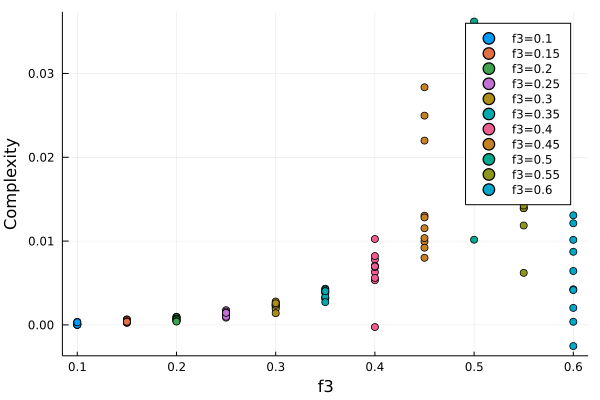

In [13]:
# scatter(f3s, mean.(compl), yerr=std.(compl)./sqrt(navg), label="Complexity")
pl = Plots.Plot()
xlabel!(pl, "f3")
ylabel!(pl, "Complexity")
for (i,f3) in pairs(f3s)
    scatter!(pl, f3*ones(navg), compl[i], label="f3=$f3")
end
pl

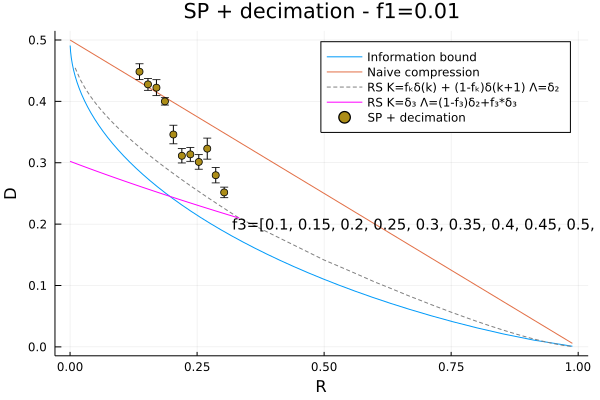

In [14]:
plot_rdb()
scatter!(Rs, D_avg, yerr=D_std, label="SP + decimation")
annotate!(0.75,0.2,Plots.text("f3="*string(collect(f3s)),10))
title!("SP + decimation - f1=$f1")

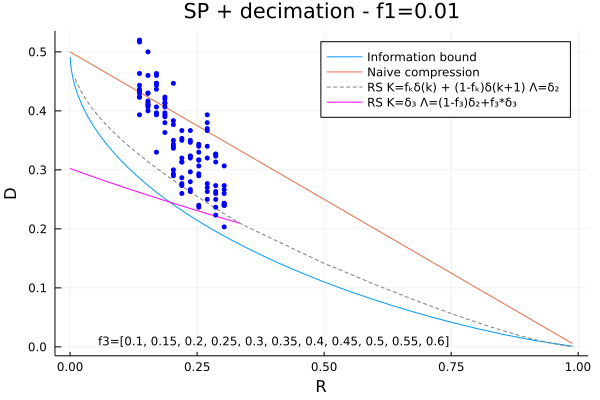

In [25]:
D_post = deepcopy(compl)
plot_rdb()
for (i,f3) in pairs(f3s)
    d = zeros(length(D_sp[i]))
    for k in 1:length(d)
        x0 = sources[i][k]
        sp = sps_post[i][k]
        mag = sign.(map(p->p'eachindex(p), sp.survey))
        x = mag .== -1
        B,indep = findbasis_slow(Array(sp.H))
        w = sparse(B*x[indep] .% 2)
        d[k] = mean(w .!= x0)
    end
    D_post[i] .= d
    scatter!(Rs[i]*ones(length(d)), d, label="", c=:blue, ms=3, msw=0)
end
annotate!(0.4,0.01,Plots.text("f3="*string(collect(f3s)),8))
title!("SP + decimation - f1=$f1")

Points for f3=0.35


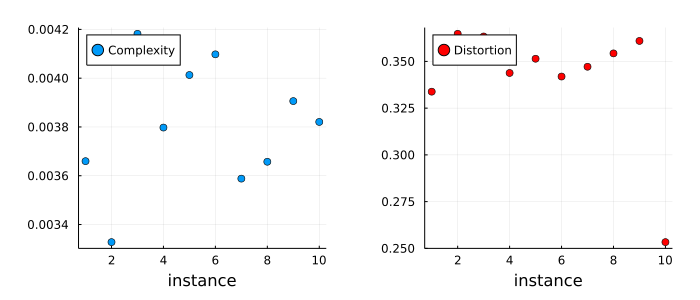

In [101]:
i = 2
# perm = sortperm(D_post[i])
perm = 1:navg
p1 = scatter(1:navg, compl[i][perm], label="Complexity", legend=:topleft, xlabel="instance")
p2 = scatter(1:navg, D_post[i][perm], c=:red, label="Distortion", legend=:topleft, xlabel="instance")
println("Points for f3=", f3s[i])
plot(p1,p2, size=(700,300), margin=5Plots.mm)

In [147]:
n = 2100
f1 = 0.01
f3 = 0.4
Λ = OffsetVector([0,f1,1-f1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
mK = sum(k*K[k] for k=eachindex(K))
mΛ = sum(d*Λ[d] for d=eachindex(Λ))
α = mΛ/mK; R = 1-α
# Single instance
nedges = Int(round(n*sum(i*l for (i,l) in pairs(Λ)), digits=8))
m = Int(nedges/3)
Ht = ldpc_matrix(n, m, nedges, Λ, K)
H = permutedims(Ht)
B,indep = findbasis(H, Ht)
x0 = bitrand(size(H,2))
s = (-1) .^ x0
init = OffsetArray(MVector{2J+1}(fill(0.0,2J+1)), -J:J)
init[-1:1] .= 1/3
sp = survey_propagation(H; field=copy(s), init, y=y);

In [148]:
decimate!(sp, indep; decsteps=1)

In [149]:
mag = sign.(map(p->p'eachindex(p), sp.survey))
x = mag .== -1
w = sparse(B*x[indep] .% 2);

In [150]:
dist = mean(w .!= x0)
R, dist

(0.20333333333333325, 0.2661904761904762)

In [52]:
plot_rdb()
scatter!([R], [dist], label="SP+decimation. f3=$f3, f1=$f1")

LoadError: UndefVarError: R not defined

In [219]:
function callback(t, ε, sp)
    t % 10 != 0 && return false
    mag = map(p->p'sign.(eachindex(p)), sp.survey)
    x = Vector(mag .< 0)
    x1 = (B*x[indep]) .% 2
    check = sum(H*x .%2)
    println("$t $check $(sum(x .!= x0)/length(x)) $(sum(x1 .!= x0)/length(x))")
    return check == 0
end
iteration!(sp, maxiter=100000, tol=1e-5, damp=0.2, rein=0.1, callback=callback)

10 281 0.202 0.2833333333333333
20 262 0.20477777777777778 0.27844444444444444
30 236 0.20666666666666667 0.2713333333333333
40 239 0.207 0.27444444444444444
50 215 0.20966666666666667 0.27155555555555555
60 207 0.21 0.27044444444444443
70 199 0.21166666666666667 0.2728888888888889
80 188 0.21244444444444444 0.2693333333333333
90 167 0.21266666666666667 0.27055555555555555
100 170 0.21222222222222223 0.27255555555555555
110 165 0.2127777777777778 0.2688888888888889
120 160 0.2137777777777778 0.2703333333333333
130 142 0.21555555555555556 0.26944444444444443
140 140 0.21544444444444444 0.2653333333333333
150 133 0.21644444444444444 0.2657777777777778
160 133 0.21755555555555556 0.2598888888888889
170 111 0.219 0.259
180 97 0.22022222222222224 0.25733333333333336
190 77 0.2212222222222222 0.25266666666666665
200 77 0.22155555555555556 0.24988888888888888
210 62 0.22233333333333333 0.247
220 73 0.222 0.24855555555555556
230 72 0.22211111111111112 0.2511111111111111
240 67 0.223 0.25111111

In [206]:
mag = map(p->p'eachindex(p), sp.survey);
x = Vector(mag .< 0)
xbase = B*(x[indep]) .% 2;

In [207]:
all(sign.(mag[indep]) == sign.(sp.efield[indep])) 

false

In [208]:
@show sum(x .!= x0)/length(xbase) 
@show sum(H*x .% 2)
@show sum(xbase .!= x0)/length(xbase)
@show sum(H*xbase .%2)/size(H,1)

sum(x .!= x0) / length(xbase) = 0.2058888888888889
sum((H * x) .% 2) = 235
sum(xbase .!= x0) / length(xbase) = 0.26766666666666666
sum((H * xbase) .% 2) / size(H, 1) = 0.0


0.0

In [209]:
sum(p[begin] for p in sp.survey)

2.2417460331495522e-69

In [128]:
[p[[-sp.J,sp.J]] for p in sp.survey[indep]]

2405-element Vector{Vector{Float64}}:
 [0.0, 1.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [1.0, 0.0]
 [0.0, 1.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [0.0, 1.0]
 ⋮
 [1.0, 0.0]
 [0.0, 1.0]
 [1.0, 0.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [1.0, 0.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [1.0, 0.0]
 [0.0, 1.0]

In [27]:
using ProgressMeter
callback(t,fg) = nothing;#println("$t $(fg.belief[1:4])")

nsamples = 10
fg = maxsum(H,  1 .- 2y .+ 1e-8*randn(N));

# the mapping is (0,1)=>(1,-1)
dist = map(1:nsamples) do i
    y = rand((0,1), N)
    fg.M .= 0
    fg.efield .= 1 .- 2y .+ 1e-8*randn(N)
    iteration!(fg; maxiter=2000, γ=1e-3, callback=callback)
    x = Int.(fg.belief .< 0)
    c = sum(fg.H'x .% 2)
    d = sum(x .⊻ y)/N
    @show d c
    x1 = B*x[indep] .% 2; d1 = sum(x1 .⊻ y)/N; c1 = sum(fg.H'x1 .% 2); @show d1 c1 
    d1
end
sum(dist)/nsamples

LoadError: UndefVarError: y not defined

In [28]:
1-M/N,sum(dist)/nsamples

LoadError: UndefVarError: dist not defined

In [29]:
x=[1:10;]; f=(x .% 2 .== 1);x[findall(f)]==x[f]

true

In [52]:
dist = map(1:10) do i
    Random.seed!(i)
    
    y = rand((0,1), N)

    lm = LossyModelGF2(fg, zeros(N), Inf, 1.0, y)
    
    function checker()
        v = (B*((fg.fields .< 0)[indep])) .% 2;
        dist = sum(v .⊻ y)/N
        check = sum(H*(fg.fields .< 0) .% 2)
        check, dist
    end

    independent = falses(N)
    independent[indep] .= true
    res_fg = solve!(lm, fg, randseed=1, verbose=true, showprogress=true, 
        independent=independent, basis = B)
#    res_fg = solve!(lm, fg, randseed=1, verbose=true, showprogress=true)
    avg_dist = res_fg.distortion 
    check, dist = checker()
    @show dist check avg_dist
    dist
end

Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.24287749287749288
check = 1
avg_dist = 0.4309116809116809


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.24786324786324787
check = 1
avg_dist = 0.4309116809116809


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.25427350427350426
check = 1
avg_dist = 0.4537037037037037


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.26495726495726496
check = 5
avg_dist = 0.4565527065527066


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.2378917378917379
check = 1
avg_dist = 0.42592592592592593


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.26851851851851855
check = 4
avg_dist = 0.4423076923076923


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.245014245014245
check = 6
avg_dist = 0.4458689458689459
dist = 0.24715099715099714
check = 0
avg_dist = 0.24715099715099714


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.25427350427350426
check = 2
avg_dist = 0.44515669515669515
dist = 0.24857549857549857
check = 0
avg_dist = 0.24857549857549857


10-element Vector{Float64}:
 0.24287749287749288
 0.24786324786324787
 0.25427350427350426
 0.26495726495726496
 0.2378917378917379
 0.26851851851851855
 0.245014245014245
 0.24715099715099714
 0.25427350427350426
 0.24857549857549857

In [53]:
dev = sqrt(sum(dist.^2)/length(dist)-(sum(dist)/length(dist))^2)/sqrt(length(dist))
1-M/N, sum(dist)/length(dist)

(0.24002849002849003, 0.2511396011396011)